# survey experiments: v0

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,freq_takeout_food,v_type,g_cost,d_cost,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,1,liquor store,0,0,20,15,0,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,1,liquor store,3,0,20,20,0,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,1,take-out food,0,3,45,20,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,1,prescription medications,10,0,30,360,0,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,1,liquor store,5,0,45,45,0,0,-5,0


In [6]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

## Focus on v0 : take-out food delivery

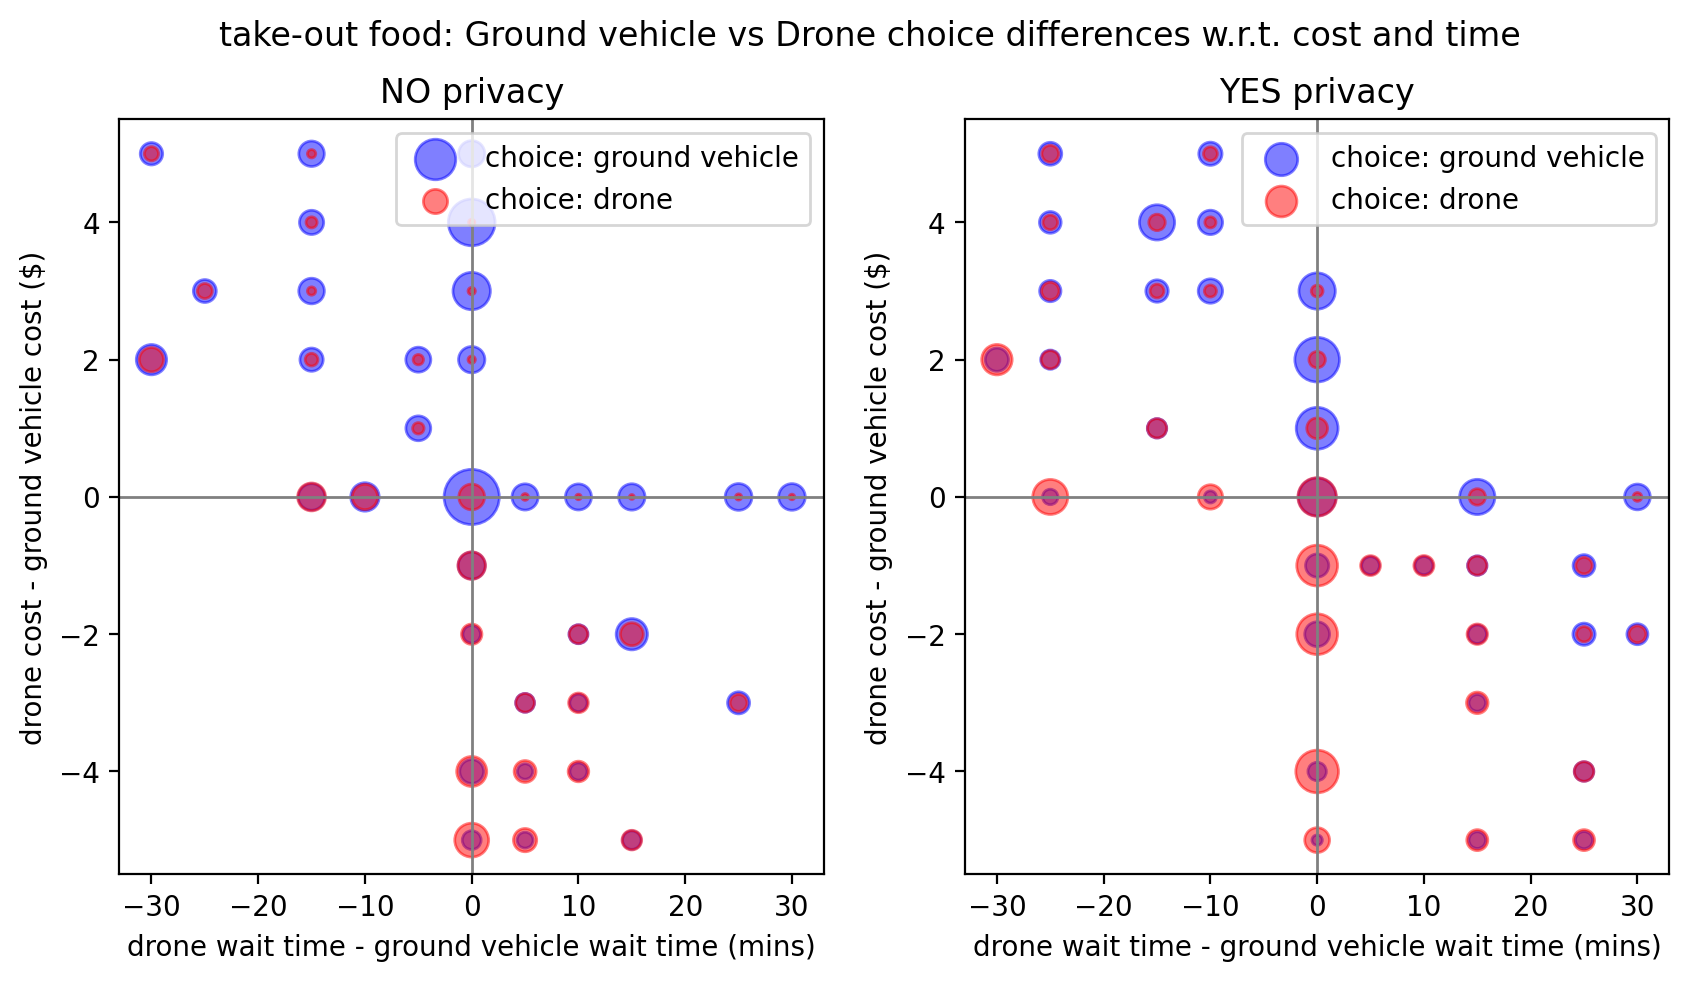

In [7]:
v=0
vdf = choices_df[choices_df['v']==v]
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0])

## Dummy models



In [8]:
from pymer4.models import Lmer

In [9]:
usecols = [
    'choice',
    'd_time - g_time',
    'd_cost - g_cost',
    'd_privacy',
    'ResponseId'
]
v_choices_df = vdf[usecols]
# make d_time - g_time, d_cost - g_cost strings that can go in formula
formula = 'choice ~ d_time_minus_g_time + d_cost_minus_g_cost + d_privacy + (1|ResponseId)'
m = Lmer(formula, data=v_choices_df.rename(columns={
        'd_time - g_time':'d_time_minus_g_time',
        'd_cost - g_cost':'d_cost_minus_g_cost',
    }), family='binomial')
print(m.fit())

Formula: choice~d_time_minus_g_time+d_cost_minus_g_cost+d_privacy+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 9528	 Groups: {'ResponseId': 3014.0}

Log-likelihood: -4840.640 	 AIC: 9691.279

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  2.576  1.605

No random effect correlations specified

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.566  -1.692   -1.440  0.064  0.209      0.184   
d_time_minus_g_time    -0.086  -0.093   -0.080  0.003  0.917      0.912   
d_cost_minus_g_cost    -0.724  -0.765   -0.683  0.021  0.485      0.465   
d_privacy               1.341   1.203    1.479  0.071  3.823      3.329   

                     OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)               0.237  0.173        0.156         0.192 -24.329   
d_time_minus_g_time       0.923  0.478        0.477         0.480 -27.036   
d_cost_minus_g

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


### Initial simple experiments

#### Generic vs alternative specific attributes.
We want to use alternative specific attributes, but start with generic.


#### Random coefficients
We want to model random effects/taste variation with a random parameter logit model. However, we start without this.


#### Iterative modeling process:

Start simplest, add complexity and use statistical tests to determine whether changes to the model add significant explanatory power.

Tests used:
- (baseline) verify parameters have expended signs
- (simplest) t-test: use t-test values and p-values to evaluate whether a parameter is statistically significant
- adjusted likelihood ratio index (rho bar squared) $\bar{\rho^2}$: evaluate whether adding a variable had a positive impact on this metric
- use likelihood ratio test

Modeling steps:

- generic model without free parameter
- add free paramter and test whether it adds statistically siginicant explanatory power
- test alternatve specific time parameter
- test alternative specific cost parameter
- -- not for now: test impact of random coefficients
    - this is not done in related work by Haan et al (2021); complicates estimation of VOT?
- test addition of socioeconomic variables and interactions with privacy parameter:
    - gender
    - age: dummy variable for older; dummy variable for younger
    - residential type: dummy variables:
        - private home, apartment
    - residential area: dummy:
        - urban, suburban, rural
- test addition of consumer behavior and interactions with privacy parameter:
    - dummy variables:
        - online shopping more than 1x/week
        - take-out food delivery more than 1x/week


#### Test with $\bar{\rho^2}$

Ben Akiva & Lerman (1985):

For the same estimation data set, the $\rho^2$ of a model always increases or at least stays the same whenever new variables are added to the model, a limitation it shares with regression statistic $R^2$. For this reason we also use the adjusted likelihood ratio index (rho bar squared):

$$
\bar{\rho^2} = 1 - \frac{L(\tilde{\beta}) - K }{L(0)}
$$
where K denotes the number of unknown parameters in the model.

#### Test with likelihood ratio test: generic vs alternative-specific attributes

Specify models with both generic and alternative-specific attributes.

Then use the likelihood ratio test (pages 28 and 164-167 in Ben Akiva & Lerman (1985)) to test which model specification should be used.

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e. for cost and time:

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$ & $\beta_{g\_time} = \beta_{d\_time}$

The test statistic for the null hypothesis is 

$-2(L_R - L_U)$

which is asymtotically distributed as $X^2$ with $df = K_U - K_R$ degrees of freedom, where $K_U$, $K_R$ are the number of estimated parameters in the unrestricted and restricted models.

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom.

In [10]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [11]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    'g_free',
    'd_free',
    'g_time',     # ground vehicle delivery wait time
    'd_time',     # drone delivery wait time
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'age_young',
    'age_old',
    'residence_house',
    'residence_apartment',
    'urban',
    'suburban',
    'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
    
]

In [12]:
model_df = choices_df[choices_df['v']==v][model_choice_cols]
print('choices without excluding free alternatives: N=%s'%len(model_df))
model_df.head(7)

choices without excluding free alternatives: N=9528


,ID,choice,g_cost,d_cost,g_time,d_time,d_privacy,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food
2,0,0,0,3,45,20,0,1,1,0,0,1,1,0,0,0,1
9,0,1,1,0,20,20,0,1,1,0,0,1,1,0,0,0,1
10,0,1,5,1,15,15,0,1,1,0,0,1,1,0,0,0,1
12,1,0,3,5,45,15,1,0,1,0,1,0,0,1,0,0,0
16,1,1,3,0,20,45,0,0,1,0,1,0,0,1,0,0,0
17,1,1,1,0,15,30,1,0,1,0,1,0,0,1,0,0,0
26,2,1,5,3,15,15,1,0,0,0,1,0,0,1,0,0,0


In [13]:
def get_vendor_panel_database(v, name=None):
    """Returns new fresh database each time."""
    db_name = name if name else 'v%s'%v
    df = choices_df[choices_df['v']==v][model_choice_cols]
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [14]:
database = get_vendor_panel_database(v)
database.data.head()

,ID,choice,g_cost,d_cost,g_time,d_time,d_privacy,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
0,0,0,0,3,45,20,0,1,1,0,0,1,1,0,0,0,1,1,0,1
1,0,1,1,0,20,20,0,1,1,0,0,1,1,0,0,0,1,0,1,1
2,0,1,5,1,15,15,0,1,1,0,0,1,1,0,0,0,1,0,0,1
3,1,0,3,5,45,15,1,0,1,0,1,0,0,1,0,0,0,0,0,2
4,1,1,3,0,20,45,0,0,1,0,1,0,0,1,0,0,0,0,1,2


In [15]:
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. Use all the
# Pandas functions to invesigate the database
database.data.describe()

,ID,choice,g_cost,d_cost,g_time,d_time,d_privacy,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
count,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000,9528.000000
mean,1837.509761,0.390848,2.130668,2.154912,27.115869,26.349181,0.520886,0.505668,0.519521,0.114295,0.699622,0.278652,0.288728,0.563287,0.141058,0.213161,0.075567,0.228484,0.239505,1500.915302
std,1076.538800,0.487966,1.893798,1.854624,11.506836,10.677340,0.499590,0.499994,0.499645,0.318186,0.458446,0.448360,0.453195,0.496005,0.348100,0.409562,0.264318,0.419878,0.426804,868.708959
min,0.000000,0.000000,0.000000,0.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,901.250000,0.000000,1.000000,1.000000,15.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,749.750000
50%,1814.500000,0.000000,1.000000,1.000000,20.000000,20.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1489.500000
75%,2774.250000,1.000000,3.000000,3.000000,30.000000,30.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2253.250000
max,3714.000000,1.000000,5.000000,5.000000,45.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3014.000000


In [16]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

def print_biogeme_results(results):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    print(results.getEstimatedParameters())
    print('\n---- Model statistics ----\n')
    print('sample size: N=%s' % results.data.sampleSize)
    print('observations: n=%s' % results.data.numberOfObservations)
    print('no. of parameters: K=%s' % results.data.nparam)
    print('log likelihood: LL=%s' % results.data.logLike)
    print('adjusted likelihood ratio index: rho-bar-squared:=%s' % results.data.rhoBarSquare)
    

### Simplest generic model

In [50]:
# without the random utility model we estimate models without using PanelLikelihoodTrajectory
# This is based on instruction from Professor Bierlaire (Biogeme author)
# see https://groups.google.com/g/biogeme/c/1CDNIpQoGPw

In [51]:
"""
Generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * g_time
V_drone =  B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy
(drone used as reference for ASC's)
"""

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G = Beta('ASC_G', 0, None, None, 0)
ASC_D = Beta('ASC_D', 0, None, None, 1) # 1: this will not change and will make this the reference for ASC's
B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)
# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'v%s_generic_logit_1'%v
# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
generic_logit_results = biogeme.estimate()
print_biogeme_results(generic_logit_results)

Model: v0_generic_logit_1

---- Coefficients ----
               Value   Std err     t-test  p-value  Rob. Std err  Rob. t-test  \
ASC_G       1.167241  0.069579  16.775739      0.0      0.069075    16.898070   
B_COST     -0.504514  0.022493 -22.429969      0.0      0.022618   -22.305561   
B_DPRIVACY  0.966648  0.089865  10.756657      0.0      0.089030    10.857495   
B_TIME     -0.065328  0.003927 -16.636177      0.0      0.003973   -16.444815   

            Rob. p-value  
ASC_G                0.0  
B_COST               0.0  
B_DPRIVACY           0.0  
B_TIME               0.0  

---- Model statistics ----

sample size: N=3014
observations: n=9528
no. of parameters: K=4
log likelihood: LL=-1620.7089749262927
adjusted likelihood ratio index: rho-bar-squared:=0.22230936263638046


In [52]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = generic_logit_results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)

VOT: willing ot pay $0.13 to save 1 minute of time


### Alternative specific variance

We have panel data and reason to assume that the preference for drone/ground delivery is highly variable among individuals and should capture that agent level effect. We do this by specifying an alternative specific variance model.

Here the parameters for time, cost, and the ASC's are randomly
distributed with a normal distribution.

For the ASCs:
The normalization is not arbitrary. Only the minimum variance alternative should be normalized to 0. Therefore, proper estimation first requires the unidentified model be estimated (with all 2 variances in this case). Then the model should be re-estimated with the smallest variance from the unidentified model normalized to 0.

We therefore do this in 2 stages below.

1. Estimate all variances
2. Fix minimum variance alternative to 0. Also use the parameter values from (1) as starting values for faster estimation.

For 1,2, see Biogeme's files for example: 12panel,13panel.

In [53]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

1. estimate all ASC variances to identify minimum variance alternative.

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # initially fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0)
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
logger = msg.bioMessage()
# logger.setSilent() #.setWarning()
logger.setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'Initial estimation of model with alternative specific variance. '
        'Rerun this model where the minimum variance ASC is fixed to 0.'
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_1'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

100 draws
start time: 14:44:33
[14:44:33] < Warning >   Cannot read file __v0_generic_logit_asc_variance_1.iter. Statement is ignored.
end time: 14:44:58
Model: v0_generic_logit_asc_variance_1

---- Coefficients ----
               Value   Std err     t-test   p-value  Rob. Std err  \
ASC_D_MEAN -1.599508  0.066192 -24.164563  0.000000      0.069030   
ASC_D_S     0.416116  0.327444   1.270802  0.203799      0.356097   
ASC_G_S     1.679653  0.102266  16.424360  0.000000      0.111081   
B_COST     -0.734569  0.021154 -34.724594  0.000000      0.023345   
B_DPRIVACY  1.371970  0.071938  19.071581  0.000000      0.076824   
B_TIME     -0.087818  0.003245 -27.059144  0.000000      0.003410   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -23.171278      0.000000  
ASC_D_S        1.168546      0.242587  
ASC_G_S       15.121034      0.000000  
B_COST       -31.466239      0.000000  
B_DPRIVACY    17.858604      0.000000  
B_TIME       -25.750346      0.000000  

---- Model statist

The variance for the drone is not statistically significant, has a large standard error.

For convenience, we use the same specification here as for v2:

We estimate the models with the ground vehicle ASC normalized to 0.

For completeness, we continue with step 2.

In [54]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = B_cost * g_cost + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

2. Fix minimum variance alternative to 0. 
Also use the parameter values from (1) as starting values for faster estimation.

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1.6, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'Second estimation of model with alternative specific variance. '
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_2'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

200 draws
start time: 14:45:25
[14:45:25] < Warning >   Cannot read file __v0_generic_logit_asc_variance_2.iter. Statement is ignored.
end time: 14:46:42
Model: v0_generic_logit_asc_variance_2

---- Coefficients ----
               Value   Std err     t-test   p-value  Rob. Std err  \
ASC_D_MEAN -1.599412  0.066573 -24.025101  0.000000      0.070151   
ASC_D_S     1.740125  0.069681  24.972648  0.000000      0.075592   
ASC_G_S    -0.022185  0.722953  -0.030687  0.975519      1.245183   
B_COST     -0.735308  0.021229 -34.637712  0.000000      0.023464   
B_DPRIVACY  1.369390  0.072105  18.991670  0.000000      0.077121   
B_TIME     -0.087655  0.003251 -26.962176  0.000000      0.003418   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -22.799517      0.000000  
ASC_D_S       23.020053      0.000000  
ASC_G_S       -0.017817      0.985785  
B_COST       -31.338143      0.000000  
B_DPRIVACY    17.756358      0.000000  
B_TIME       -25.641852      0.000000  

---- Model statist

In [55]:
results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-1.599412,0.066573,0.000000
ASC_D_S,1.740125,0.069681,0.000000
B_COST,-0.735308,0.021229,0.000000
B_DPRIVACY,1.369390,0.072105,0.000000
B_TIME,-0.087655,0.003251,0.000000
ASC_G_S,-0.022185,0.722953,0.975519


In [56]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)

VOT: willing ot pay $0.12 to save 1 minute of time


#### Results

The VOT barely changed (good).

The $\bar{\rho^2}$ is improved over the model without the alternative specific variance -- indicating the alternative specific variance model is an improvement.


#### Adding a coefficient for free

In [57]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1.6, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
logger = msg.bioMessage()
logger.setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test free after alternative specific variance'
    )
)
biogeme.modelName = 'v%s_generic_asv_free'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

200 draws
start time: 14:48:16
[14:48:16] < Warning >   Cannot read file __v0_generic_asv_free.iter. Statement is ignored.
end time: 14:49:42
Model: v0_generic_asv_free

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -1.614014  0.066825 -24.152705  0.000000e+00      0.070098   
ASC_D_S     1.745625  0.070737  24.677718  0.000000e+00      0.076537   
ASC_G_S     0.052094  0.635836   0.081929  9.347028e-01      0.954433   
B_COST     -0.678594  0.022640 -29.973208  0.000000e+00      0.023957   
B_DPRIVACY  1.370788  0.072318  18.955110  0.000000e+00      0.077181   
B_FREE      0.415841  0.068357   6.083350  1.176974e-09      0.067789   
B_TIME     -0.088784  0.003277 -27.091316  0.000000e+00      0.003452   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -23.025195  0.000000e+00  
ASC_D_S       22.807461  0.000000e+00  
ASC_G_S        0.054581  9.564724e-01  
B_COST       -28.325519  0.000000e+00  
B_DPRIVACY    17.76078

In [58]:
results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-1.614014,0.066825,0.000000e+00
ASC_D_S,1.745625,0.070737,0.000000e+00
B_COST,-0.678594,0.022640,0.000000e+00
B_DPRIVACY,1.370788,0.072318,0.000000e+00
B_TIME,-0.088784,0.003277,0.000000e+00
B_FREE,0.415841,0.068357,1.176974e-09
ASC_G_S,0.052094,0.635836,9.347028e-01


In [59]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)

VOT: willing ot pay $0.13 to save 1 minute of time


In [61]:
# what is the value of free? How much extra time would you wait?
# FREE/TIME
tradeoff = 0.418941/0.088799
print('willing to trade %0.2f minutes of time for free?' % tradeoff)

willing to trade 4.72 minutes of time for free?


#### Results

Overall, adding a coefficient to represent whether delivery is free seems to improve the model.

- free coefficient statistically significant
- improved value for $\bar{\rho^2}$
- VOT barely changed (increased by $0.01) even though free is statistically significant


### Modeling with alternative-specific attributes

We use above model with generic time and cost coefficients as the restricted model.

We then test a (unrestricted model) specification with alternative specific cost coefficient.

In [63]:
# get previous model results (restricted model) for comparison
restricted_results = results

#### Test alternative specific time coefficient

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_time} = \beta_{d\_time}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [64]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_g_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_d_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
time coefficient is alternative specific

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', -1.6, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_G_TIME = Beta('B_G_TIME', 0, None, None, 0)
B_D_TIME = Beta('B_D_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_G_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_D_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
logger = msg.bioMessage()
logger.setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test alternative specific time coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_time'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(unrestricted_results)

200 draws
start time: 18:36:13
[18:36:13] < Warning >   Cannot read file __v0_as_time.iter. Statement is ignored.
end time: 18:37:38
Model: v0_as_time

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -1.356350  0.123942 -10.943463  0.000000e+00      0.123583   
ASC_D_S    -1.137213  0.276607  -4.111293  3.934495e-05      0.235058   
ASC_G_S     1.333177  0.238652   5.586280  2.319846e-08      0.198634   
B_COST     -0.678060  0.022738 -29.820227  0.000000e+00      0.024170   
B_DPRIVACY  1.382514  0.072663  19.026330  0.000000e+00      0.077031   
B_D_TIME   -0.093691  0.003900 -24.020871  0.000000e+00      0.004012   
B_FREE      0.400315  0.068704   5.826622  5.656038e-09      0.067924   
B_G_TIME   -0.084056  0.003820 -22.005608  0.000000e+00      0.003907   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -10.975253  0.000000e+00  
ASC_D_S       -4.838004  1.311498e-06  
ASC_G_S        6.711721  1.923417e-11  
B_COST 

Perform the likelihood ratio test

In [65]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_2,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=9.7334
X_2,0.05 = 3.84
can reject the null hypothesis


#### Test alternative specific cost coefficient


Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [66]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
cost coefficient is alternative specific

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1.6, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_G_COST*g_cost + B_FREE*g_free + B_TIME*g_time
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
logger = msg.bioMessage()
logger.setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test alternative specific cost coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_cost'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(unrestricted_results)

200 draws
start time: 18:37:41
[18:37:41] < Warning >   Cannot read file __v0_as_cost.iter. Statement is ignored.
end time: 18:39:42
Model: v0_as_cost

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -1.601941  0.083311 -19.228493  0.000000e+00      0.083662   
ASC_D_S     1.745517  0.070855  24.635048  0.000000e+00      0.076700   
ASC_G_S     0.053797  0.628846   0.085549  9.318252e-01      0.933229   
B_DPRIVACY  1.372508  0.072660  18.889379  0.000000e+00      0.077626   
B_D_COST   -0.682451  0.027694 -24.642431  0.000000e+00      0.028635   
B_FREE      0.413720  0.068903   6.004342  1.921098e-09      0.068105   
B_G_COST   -0.676263  0.024575 -27.517856  0.000000e+00      0.025623   
B_TIME     -0.088861  0.003294 -26.974887  0.000000e+00      0.003470   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -19.147781  0.000000e+00  
ASC_D_S       22.757651  0.000000e+00  
ASC_G_S        0.057646  9.540306e-01  
B_DPRIV

Perform the likelihood ratio test

In [67]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_1,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=0.0589
X_1,0.05 = 3.84
cannot reject the null hypothesis


#### Results overview

This is different from v2!

- results show time should be alternative specific
- results show cost should not be alternative specific
- this is the reverse from v2

It also makes sense that time is more sensitive here, given that here v0 is take-out food, which is time-sensitive.

v2 is liquor store, which is less time sensitive.

For now we hold off on alternative specific variables and continue on to socioeconomic and consumer variables

### Socioeconomic variables and interactions with privacy parameter

We add in the following parameters which we assume are generic across drone and ground vehicle delivery.

- gender: male/other (1/0)
- age: age_young, age_old (0/1)
- residential type: residence_house, residence_apartment (0/1)
- residential area: urban, suburban, rural (0/1)

In [17]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy
    + B_male * male + B_gender_privacy * gender * d_privacy
    + B_age_young * age_young + B_age_old * age_old
    + B_residence_house * residence_house 
    + B_residence_apartment * residence_apartment
    + B_urban * urban 
    + B_suburban * suburban 
    + B_rural * rural
    + [demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1.6, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
# B_D_COST = Beta('B_D_COST', 0, None, None, 0)
# B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_RESIDENCE_HOUSE = Beta('B_RESIDENCE_HOUSE', 0, None, None, 0)
B_RESIDENCE_APARTMENT = Beta('B_RESIDENCE_APARTMENT', 0, None, None, 0)
B_RESIDENCE_HOUSE_PRIVACY = Beta('B_RESIDENCE_HOUSE_PRIVACY', 0, None, None, 0)
B_RESIDENCE_APARTMENT_PRIVACY = Beta('B_RESIDENCE_APARTMENT_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
B_RURAL = Beta('B_RURAL', 0, None, None, 0)
B_URBAN_PRIVACY = Beta('B_URBAN_PRIVACY', 0, None, None, 0)
B_SUBURBAN_PRIVACY = Beta('B_SUBURBAN_PRIVACY', 0, None, None, 0)
B_RURAL_PRIVACY = Beta('B_RURAL_PRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*g_time

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_DPRIVACY*d_privacy \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_RESIDENCE_APARTMENT*residence_apartment + B_RESIDENCE_APARTMENT_PRIVACY*residence_apartment*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy \
    + B_RURAL*rural + B_RURAL_PRIVACY*rural*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test with socioeconomic variables'
    )
)
biogeme.modelName = 'v%s_demographics'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demo_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(demo_results)

200 draws
start time: 12:24:10
[12:24:10] < Warning >   Cannot read file __v0_demographics.iter. Statement is ignored.
end time: 12:36:47
Model: v0_demographics

---- Coefficients ----
                                  Value   Std err     t-test       p-value  \
ASC_D_MEAN                    -2.272524  0.767006  -2.962851  3.048038e-03   
ASC_D_S                        1.086302  0.268616   4.044064  5.253254e-05   
ASC_G_S                       -1.346427  0.219391  -6.137103  8.403995e-10   
B_AGE_OLD                     -0.428383  0.200435  -2.137267  3.257625e-02   
B_AGE_OLD_PRIVACY             -0.019608  0.231574  -0.084671  9.325228e-01   
B_AGE_YOUNG                   -0.108255  0.125430  -0.863071  3.880985e-01   
B_AGE_YOUNG_PRIVACY            0.525215  0.143779   3.652926  2.592694e-04   
B_COST                        -0.684505  0.022747 -30.092408  0.000000e+00   
B_DPRIVACY                     2.083533  0.860857   2.420303  1.550759e-02   
B_FREE                         0.41

In [18]:
demo_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
B_TIME,-0.089525,0.003289,0.000000e+00
B_COST,-0.684505,0.022747,0.000000e+00
ASC_G_S,-1.346427,0.219391,8.403995e-10
B_FREE,0.413025,0.068484,1.629429e-09
B_MALE,0.590465,0.116893,4.387044e-07
ASC_D_S,1.086302,0.268616,5.253254e-05
B_AGE_YOUNG_PRIVACY,0.525215,0.143779,2.592694e-04
ASC_D_MEAN,-2.272524,0.767006,3.048038e-03
B_DPRIVACY,2.083533,0.860857,1.550759e-02
B_MALE_PRIVACY,-0.298758,0.133313,2.502476e-02


#### Results overview

age:
- older ppl less likely to choose drone
- young age has no significance on likelihood to choose drone
- *young ppl value privacy more*
- TODO? could further pick apart age levels

gender
- males prefer drone more than others
- males value privacy less than others

no significant coefficients for residential areas/types


### Consumer behavior attributes and interactions with privacy parameter

We add in the following attributes which we assume are generic across drone and ground vehicle delivery.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week

In [20]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)


# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*g_time

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy \
    + B_FREQ_TAKEOUT_FOOD*freq_takeout_food \
    + B_FREQ_TAKEOUT_FOOD_PRIVACY*freq_takeout_food*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test with consumer behavior variables'
    )
)
biogeme.modelName = 'v%s_freq_consumer'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(cons_results)

200 draws
start time: 12:44:42
[12:44:42] < Warning >   Cannot read file __v0_freq_consumer.iter. Statement is ignored.
end time: 12:52:26
Model: v0_freq_consumer

---- Coefficients ----
                                Value   Std err     t-test       p-value  \
ASC_D_MEAN                  -1.661192  0.074803 -22.207651  0.000000e+00   
ASC_D_S                      1.737633  0.079888  21.750865  0.000000e+00   
ASC_G_S                      0.136093  0.541333   0.251404  8.015016e-01   
B_COST                      -0.678728  0.022637 -29.982657  0.000000e+00   
B_DPRIVACY                   1.368225  0.081137  16.863228  0.000000e+00   
B_FREE                       0.417567  0.068373   6.107170  1.014131e-09   
B_FREQ_ECOMMERCE             0.290388  0.142077   2.043876  4.096579e-02   
B_FREQ_ECOMMERCE_PRIVACY    -0.046175  0.164089  -0.281402  7.784020e-01   
B_FREQ_TAKEOUT_FOOD         -0.213828  0.216853  -0.986049  3.241092e-01   
B_FREQ_TAKEOUT_FOOD_PRIVACY  0.160534  0.252012   0.6

In [21]:
cons_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-1.661192,0.074803,0.000000e+00
ASC_D_S,1.737633,0.079888,0.000000e+00
B_COST,-0.678728,0.022637,0.000000e+00
B_DPRIVACY,1.368225,0.081137,0.000000e+00
B_TIME,-0.088778,0.003277,0.000000e+00
B_FREE,0.417567,0.068373,1.014131e-09
B_FREQ_ECOMMERCE,0.290388,0.142077,4.096579e-02
B_FREQ_TAKEOUT_FOOD,-0.213828,0.216853,3.241092e-01
B_FREQ_TAKEOUT_FOOD_PRIVACY,0.160534,0.252012,5.241197e-01
B_FREQ_ECOMMERCE_PRIVACY,-0.046175,0.164089,7.784020e-01


#### Results overview

- ppl who do frequent ecommerce have a greater preference for drone

### Plots



Make a plot:

- x-axis: chose drone: male, non-male
- y-axis: choice frequency (%)

Make a table:
```
gender, drone choice
```

,drone choice,count
male,,
non-male,0.36518,4710
male,0.41594,4818


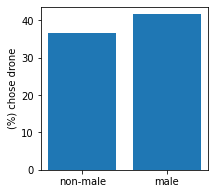

In [25]:
gendered_df = (
    model_df.groupby('male').agg({'choice':'mean', 'ID':'count'})
    .rename(columns={'ID':'count','choice':'drone choice'})
    .rename({0:'non-male',1:'male'}) # index
)
fig,ax = plt.subplots(figsize=(3,3))
ax.bar(gendered_df.index, gendered_df['drone choice']*100)
_ = ax.set_ylabel('(%) chose drone')
gendered_df

Do the same for age:old vs everyone else

,drone choice,count
age_old,,
not age:old,0.399692,8439
age:old,0.322314,1089


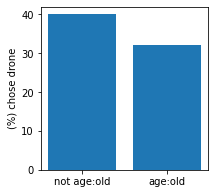

In [26]:
age_old_df = (
    model_df.groupby('age_old').agg({'choice':'mean', 'ID':'count'})
    .rename(columns={'ID':'count','choice':'drone choice'})
    .rename({1:'age:old',0:'not age:old'}) # index
)
fig,ax = plt.subplots(figsize=(3,3))
ax.bar(age_old_df.index, age_old_df['drone choice']*100)
_ = ax.set_ylabel('(%) chose drone')
age_old_df